<a href="https://colab.research.google.com/github/hanggao811/AnomalyDetectionLIGO/blob/main/AE_fourier_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
# Imports
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Input
from matplotlib import pyplot as plt
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
import glob, re
from sklearn.base import BaseEstimator, RegressorMixin
from tensorflow.keras.models import load_model as keras_load_model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.signal import welch, csd, coherence, stft
# Set random seed
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
# Mount to googlecolab
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/new_dataset')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# Load data and normalize it
BG = np.load('O3_Background_dataset.npz')

BG_train = BG['data'][:-1024]
stds = np.std(BG_train, axis=-1)[:, :, np.newaxis]
BG_train_normed = BG_train/stds
BG_train = np.swapaxes(BG_train, 1, 2)
BG_train_normed = np.swapaxes(BG_train_normed, 1, 2)

BG_test = BG['data'][-1024:]
stds = np.std(BG_test, axis=-1)[:, :, np.newaxis]
BG_test_normed = BG_test/stds
BG_test = np.swapaxes(BG_test, 1, 2)
BG_test_normed = np.swapaxes(BG_test_normed, 1, 2)

# load"SineGaussian","BBH","Gaussian","Cusp","Kink","KinkKink","WhiteNoiseBurst"
signal = np.load('O3_rescaled_signals_dataset.npz')
snr = signal['snr']
# seven = np.where(snr>7)
signal_label = signal['label']

SG_index = np.where(signal_label == 2)
# SG_index = np.intersect1d(SG_index, seven)
SG = signal['data'][SG_index]
stds = np.std(SG, axis=-1)[:, :, np.newaxis]
SG_normed = SG/stds
SG = np.swapaxes(SG, 1, 2)
SG_normed = np.swapaxes(SG_normed, 1, 2)

BBH_index = np.where(signal_label == 3)
# BBH_index = np.intersect1d(BBH_index, seven)
BBH = signal['data'][BBH_index]
stds = np.std(BBH, axis=-1)[:, :, np.newaxis]
BBH_normed = BBH/stds
BBH = np.swapaxes(BBH, 1, 2)
BBH_normed = np.swapaxes(BBH_normed, 1, 2)

Gaussian_index = np.where(signal_label == 4)
# Gaussian_index = np.intersect1d(Gaussian_index, seven)
Gaussian = signal['data'][Gaussian_index]
stds = np.std(Gaussian, axis=-1)[:, :, np.newaxis]
Gaussian_normed = Gaussian/stds
Gaussian = np.swapaxes(Gaussian, 1, 2)
Gaussian_normed = np.swapaxes(Gaussian_normed, 1, 2)

Cusp_index = np.where(signal_label == 5)
# Cusp_index = np.intersect1d(Cusp_index, seven)
Cusp = signal['data'][Cusp_index]
stds = np.std(Cusp, axis=-1)[:, :, np.newaxis]
Cusp_normed = Cusp/stds
Cusp = np.swapaxes(Cusp, 1, 2)
Cusp_normed = np.swapaxes(Cusp_normed, 1, 2)

Kink_index = np.where(signal_label == 6)
# Kink_index = np.intersect1d(Kink_index, seven)
Kink = signal['data'][Kink_index]
stds = np.std(Kink, axis=-1)[:, :, np.newaxis]
Kink_normed = Kink/stds
Kink = np.swapaxes(Kink, 1, 2)
Kink_normed = np.swapaxes(Kink_normed, 1, 2)

KinkKink_index = np.where(signal_label == 7)
# KinkKink_index = np.intersect1d(KinkKink_index, seven)
KinkKink = signal['data'][KinkKink_index]
stds = np.std(KinkKink, axis=-1)[:, :, np.newaxis]
KinkKink_normed = KinkKink/stds
KinkKink = np.swapaxes(KinkKink, 1, 2)
KinkKink_normed = np.swapaxes(KinkKink_normed, 1, 2)

WNB_index = np.where(signal_label == 8)
# WNB_index = np.intersect1d(WNB_index, seven)
WNB = signal['data'][WNB_index]
stds = np.std(WNB, axis=-1)[:, :, np.newaxis]
WNB_normed = WNB/stds
WNB = np.swapaxes(WNB, 1, 2)
WNB_normed = np.swapaxes(WNB_normed, 1, 2)

In [61]:
print('shape for background train/test' , BG_train.shape, BG_test.shape)
print('shape for SG ' , SG.shape)
print('shape for BBH ' , BBH.shape)
print('shape for Gaussian ' , Gaussian.shape)
print('shape for Cusp ' , Cusp.shape)
print('shape for Kink ' , Kink.shape)
print('shape for KinkKink ' , KinkKink.shape)
print('shape for WNB ' , WNB.shape)

shape for background train/test (254976, 200, 2) (1024, 200, 2)
shape for SG  (1036, 200, 2)
shape for BBH  (1022, 200, 2)
shape for Gaussian  (1022, 200, 2)
shape for Cusp  (1022, 200, 2)
shape for Kink  (1022, 200, 2)
shape for KinkKink  (1022, 200, 2)
shape for WNB  (1022, 200, 2)


In [62]:
# Making correlation
def add_correlation_channel(x):
    x1, x2 = x[:, :, 0], x[:, :, 1]
    corr = np.array([
        np.correlate(x1[i], x2[i], mode='same') for i in range(x.shape[0])
    ])
    return np.stack([x1, x2, corr], axis=-1)

# BG_train = add_correlation_channel(BG_train)
# BG_test = add_correlation_channel(BG_test)
# SG = add_correlation_channel(SG)
# BBH = add_correlation_channel(BBH)
# Gaussian = add_correlation_channel(Gaussian)
# Cusp = add_correlation_channel(Cusp)
# Kink = add_correlation_channel(Kink)
# KinkKink = add_correlation_channel(KinkKink)
# WNB = add_correlation_channel(WNB)

BG_train = add_correlation_channel(BG_train_normed)
BG_test = add_correlation_channel(BG_test_normed)
SG = add_correlation_channel(SG_normed)
BBH = add_correlation_channel(BBH_normed)
Gaussian = add_correlation_channel(Gaussian_normed)
Cusp = add_correlation_channel(Cusp_normed)
Kink = add_correlation_channel(Kink_normed)
KinkKink = add_correlation_channel(KinkKink_normed)
WNB = add_correlation_channel(WNB_normed)

In [63]:
# Add Psd channel using Welch with shape (N_samples, 101)
fs = 4096
##--background_psd--##
_,BG_train_psd = csd(BG_train[:,:,0], BG_train[:,:,1], fs=fs, nperseg=200)
_,BG_test_psd = csd(BG_test[:,:,0], BG_test[:,:,1], fs=fs, nperseg=200)
BG_train_psd = abs(BG_train_psd)
BG_test_psd = abs(BG_test_psd)

##--BBH_psd--##
_,BBH_psd = csd(BBH[:,:,0], BBH[:,:,1], fs=fs, nperseg=200)
BBH_psd = abs(BBH_psd)

##--SG_psd--##
_,SG_psd = csd(SG[:,:,0], SG[:,:,1], fs=fs, nperseg=200)
SG_psd = abs(SG_psd)

##--Gaussian_psd--##
_,Gaussian_psd = csd(Gaussian[:,:,0], Gaussian[:,:,1], fs=fs, nperseg=200)
Gaussian_psd = abs(Gaussian_psd)

##--Cusp_psd--##
_,Cusp_psd = csd(Cusp[:,:,0], Cusp[:,:,1], fs=fs, nperseg=200)
Cusp_psd = abs(Cusp_psd)

##--Kink_psd--##
_,Kink_psd = csd(Kink[:,:,0], Kink[:,:,1], fs=fs, nperseg=200)
Kink_psd = abs(Kink_psd)

##--KinkKink_psd--##
_,KinkKink_psd = csd(KinkKink[:,:,0], KinkKink[:,:,1], fs=fs, nperseg=200)
KinkKink_psd = abs(KinkKink_psd)

##--WNB_psd--##
_,WNB_psd = csd(WNB[:,:,0], WNB[:,:,1], fs=fs, nperseg=200)
WNB_psd = abs(WNB_psd)


# Add Psd channel using Welch with shape (N_samples, 101)
fs = 4096
nperseg = 7
##--BG_stft--##
f,t,BG_train_stft = stft(BG_train[:,:,0] , fs=fs, nperseg=nperseg)
# BG_train_stft = abs(BG_train_stft)
f,t,BG_test_stft = stft(BG_test[:,:,0], fs=fs, nperseg=nperseg)
# BG_test_stft = abs(BG_test_stft)

##--BBH_stft--##
f,t,BBH_stft = stft(BBH[:,:,0], fs=fs, nperseg=nperseg)
# bbh_stft = abs(bbh_stft)

##--SG_stft--##
f,t,SG_stft = stft(SG[:,:,0], fs=fs, nperseg=nperseg)
# sg_stft = abs(sg_stft)

##--Gaussian_stft--##
f,t,Gaussian_stft = stft(Gaussian[:,:,0], fs=fs, nperseg=nperseg)
# gaussian_stft = abs(gaussian_stft)

##--Cusp--##
f,t,Cusp_stft = stft(Cusp[:,:,0], fs=fs, nperseg=nperseg)
# cusp_stft = abs(cusp_stft)

##--Kink--##
f,t,Kink_stft = stft(Kink[:,:,0], fs=fs, nperseg=nperseg)
# kink_stft = abs(kink_stft)

##--KinkKink--##
f,t,KinkKink_stft = stft(KinkKink[:,:,0], fs=fs, nperseg=nperseg)
# kinkkink_stft = abs(kinkkink_stft)

##--WNB--##
f,t,WNB_stft = stft(WNB[:,:,0], fs=fs, nperseg=nperseg)
# wnb_stft = abs(wnb_stft)

In [64]:
# sample = np.abs(kinks_stft[-3])  # shape (freqs, time)
# plt.pcolormesh(t, f, np.log10(sample + 1e-12), shading='gouraud')

# # Then plot
# plt.pcolormesh(t, f, sample, shading='gouraud')
# plt.colorbar(label="|Zx * conj(Zy)|")
# plt.ylabel("Frequency [Hz]")
# plt.xlabel("Time [s]")
# plt.title("Cross STFT Magnitude")
# plt.tight_layout()
# plt.show()

SOLUTION GIVEN

In [65]:
tf.config.experimental.enable_op_determinism()

class Autoencoder:
    def __init__(self, input_shape=(200,3),stft_shape=(6,41), dropout=0.1, batch_size = 256, epochs = 50, lr = 1e-3,
                 f1=3,f2=16,f3=32,f4=64,k1=16,k2=32,k3=64,k4=128,s1=2,s2=2,s3=1,s4=1):
        super().__init__()
        self.input_shape = input_shape
        self.stft_shape = stft_shape
        self.f1 = f1
        self.f2 = f2
        self.f3 = f3
        self.k1 = k1
        self.k2 = k2
        self.k3 = k3
        self.s1 = s1
        self.s2 = s2
        self.s3 = s3
        self.f4 = f4
        self.k4 = k4
        self.s4 = s4
        self.dropout = dropout
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.model_ = None

    def positional_encoding(self, inputs):
        embed_size = inputs.shape[-1]
        input_length = inputs.shape[-2]
        assert embed_size % 2 == 0, 'embed_size must be even'
        p, i = np.meshgrid(np.arange(input_length), np.arange(embed_size // 2))
        pos_emb = np.empty((1,input_length, embed_size))
        pos_emb[0,:,::2] = np.sin(p/(10000**(2*i/embed_size))).T
        pos_emb[0,:,1::2] = np.cos(p/(10000**(2*i/embed_size))).T
        self.pos_encoding = tf.constant(pos_emb.astype(np.float32))
        return inputs + self.pos_encoding[:, :input_length, :]

    def build_model(self):
        inputs = keras.Input(shape=self.input_shape)
        x = inputs

        # Encoder
        print('Encoder layer shape')
        x = layers.Conv1D(filters=self.f1, kernel_size=self.k1, strides=self.s1, padding="same", activation="tanh")(x)
        print(x.shape)
        x = layers.Dropout(rate=self.dropout)(x)
        x = layers.Conv1D(filters=self.f2, kernel_size=self.k2, strides=self.s2, padding="same")(x)
        print(x.shape)
        x = layers.Conv1D(filters=self.f3, kernel_size=self.k3, strides=self.s3, padding="same")(x)
        print(x.shape)

        # Bottleneck
        print("Bottleneck shape")
        latent_x = layers.Conv1D(filters=self.f4, kernel_size=self.k4, strides=self.s4, padding="same")(x)
        print(latent_x.shape)
        x = layers.Dropout(rate=self.dropout)(latent_x)

        # Decoder Head
        print("Decoder layer shape")
        x = layers.Conv1DTranspose(filters=self.f3, kernel_size=self.k3, strides=self.s3, padding="same")(x)
        print(x.shape)
        x = layers.Conv1DTranspose(filters=self.f2, kernel_size=self.k2, strides=self.s2, padding="same")(x)
        print(x.shape)
        decoder_output = layers.Conv1DTranspose(filters=self.f1, kernel_size=self.k1, strides=1, padding="same")(x)
        print(decoder_output.shape)

        # STFT real Head
        print("STFT real layer shape")
        stft_x = layers.Flatten()(latent_x)
        print(stft_x.shape)
        stft_x = layers.Dense(self.stft_shape[0]*self.stft_shape[1])(stft_x)
        print(stft_x.shape)
        stft_x = layers.Reshape((self.stft_shape[0],self.stft_shape[1]))(stft_x)
        print(stft_x.shape)
        stft_x_output = layers.Conv1D(filters=self.stft_shape[1], kernel_size=1, strides=1, padding="same")(stft_x)
        print(stft_x_output.shape)

        # STFT imag Head
        print("STFT imag layer shape")
        stft_y = layers.Flatten()(latent_x)
        print(stft_y.shape)
        stft_y = layers.Dense(self.stft_shape[0]*self.stft_shape[1])(stft_y)
        print(stft_y.shape)
        stft_y = layers.Reshape((self.stft_shape[0],self.stft_shape[1]))(stft_y)
        print(stft_y.shape)
        stft_y_output = layers.Conv1D(filters=self.stft_shape[1], kernel_size=1, strides=1, padding="same")(stft_y)
        print(stft_y_output.shape)

        # self.model_ = keras.Model(inputs=inputs, outputs=decoder_output)
        # self.model_.compile(loss='mse',
        #                     optimizer=keras.optimizers.Adam(learning_rate=self.lr))


        self.model_ = keras.Model(inputs, outputs={"reconstructed_signal": decoder_output, "predicted_x_stft": stft_x_output, 'predicted_y_stft': stft_y_output})
        self.model_.compile(loss={"reconstructed_signal": "mse","predicted_x_stft": "mse","predicted_y_stft": "mse"},
                            loss_weights={"reconstructed_signal": 1,"predicted_x_stft": 1,"predicted_y_stft": 1},
                            optimizer=keras.optimizers.Adam(learning_rate=self.lr))


    def predict(self, X):
        return self.model_.predict(X, batch_size=self.batch_size)


In [66]:
param_set = [
    {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 32, 'f2': 16, 'f5': 3, 'k1': 16,  'k2': 32, 'k3': 64, 'k4': 128,  'k5': 5,  'lr': 0.001, 's1': 2, 's2': 2}, #0.978,0.984,0.280, before that(no correlation) 0.658,0.413,0.348
    #same feature but adding one more layer at the beginnning to make it symmetry without correlation #(None, 200, 32) (None, 100, 32) (None, 50, 16) (None, 100, 16) (None, 200, 32) (None, 200, 2)  0.942 0.968 0.346 no correlation gives 0.799 0.404 0.322
    #its not perfectly symmetric, let me try this
    {'batch_size': 700, 'dropout': 0.1, 'epochs': 50, 'f1': 3, 'f2': 8, 'f3': 32, 'f4':128, 'k1': 4,  'k2':8 , 'k3': 16, 'k4':32, 'lr': 0.001, 's1': 1, 's2': 2, 's3':2, 's4':1}


]
params = param_set[1]
AE = Autoencoder(input_shape=(200, 3),stft_shape=BG_train_stft.shape[1:], **params)
# AE = Autoencoder(input_shape=(200, 3), **params)
AE.build_model()
AE.model_.fit(BG_train,{"reconstructed_signal":BG_train,"predicted_x_stft":np.real(BG_train_stft),'predicted_y_stft':np.imag(BG_train_stft)},epochs=AE.epochs,batch_size=AE.batch_size,validation_split=0.2,verbose=1,callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])
# AE.model_.fit(BG_train,BG_train,epochs=AE.epochs,batch_size=AE.batch_size,validation_split=0.2,verbose=1,callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Encoder layer shape
(None, 200, 3)
(None, 100, 8)
(None, 50, 32)
Bottleneck shape
(None, 50, 128)
Decoder layer shape
(None, 100, 32)
(None, 200, 8)
(None, 200, 3)
STFT real layer shape
(None, 6400)
(None, 204)
(None, 4, 51)
(None, 4, 51)
STFT imag layer shape
(None, 6400)
(None, 204)
(None, 4, 51)
(None, 4, 51)
Epoch 1/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - loss: 27.3170 - predicted_x_stft_loss: 0.1780 - predicted_y_stft_loss: 0.1502 - reconstructed_signal_loss: 26.9887 - val_loss: 8.7066 - val_predicted_x_stft_loss: 0.1277 - val_predicted_y_stft_loss: 0.0937 - val_reconstructed_signal_loss: 8.4856
Epoch 2/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 8.2672 - predicted_x_stft_loss: 0.1262 - predicted_y_stft_loss: 0.0927 - reconstructed_signal_loss: 8.0483 - val_loss: 2.6895 - val_predicted_x_stft_loss: 0.1233 - val_predicted_y_stft_loss: 0.0899 - val_reconstructed_signal_loss: 2.4763
Epoch 3/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 5.6351 - predicted_x_s

In [67]:
def eval(model, bg, anomaly,label):
    bg_pred = model.predict(bg)
    anomaly_pred = model.predict(anomaly)
    bg_mse = np.mean((bg_pred - bg)**2, axis=(1,2))
    anomaly_mse = np.mean((anomaly_pred - anomaly)**2, axis=(1,2))
    true_val = np.concatenate((np.zeros(bg.shape[0]),np.ones(anomaly.shape[0])))
    pred_val = np.concatenate((bg_mse, anomaly_mse))
    fpr, tpr, thresholds = roc_curve(true_val, pred_val)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr,label=f'AUC = {auc_score:.3f}')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve of {label}")
    plt.grid(True)
    plt.legend()
    plt.show()
    return auc_score


def recon_eval(model, bg, anomaly,label):
    bg_pred = model.predict(bg)['reconstructed_signal']
    anomaly_pred = model.predict(anomaly)['reconstructed_signal']
    bg_mse = np.mean((bg_pred - bg)**2, axis=(1,2))
    anomaly_mse = np.mean((anomaly_pred - anomaly)**2, axis=(1,2))
    true_val = np.concatenate((np.zeros(bg.shape[0]),np.ones(anomaly.shape[0])))
    pred_val = np.concatenate((bg_mse, anomaly_mse))
    fpr, tpr, thresholds = roc_curve(true_val, pred_val)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr,label=f'AUC = {auc_score:.3f}')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve of {label}")
    plt.grid(True)
    plt.legend()
    plt.show()
    return auc_score

def stft_eval(model, bg, anomaly, bg_stft, anomaly_stft, label):
    bg_pred = model.predict(bg)['predicted_x_stft']+1j*model.predict(bg)['predicted_y_stft']
    anomaly_pred = model.predict(anomaly)['predicted_x_stft']+1j*model.predict(anomaly)['predicted_y_stft']
    bg_mse = np.mean((bg_pred - bg_stft)**2, axis=(1,2))
    anomaly_mse = np.mean((anomaly_pred - anomaly_stft)**2, axis=(1,2))
    true_val = np.concatenate((np.zeros(bg.shape[0]),np.ones(anomaly.shape[0])))
    pred_val = np.concatenate((bg_mse, anomaly_mse))
    fpr, tpr, thresholds = roc_curve(true_val, abs(pred_val))
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr,label=f'AUC = {auc_score:.3f}')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve of {label}")
    plt.grid(True)
    plt.legend()
    plt.show()
    return auc_score

In [68]:
# BBH_auc = eval(AE, BG_test, BBH, 'bbh')
# SG_auc = eval(AE, BG_test, SG, 'sglf')
# WNB_auc = eval(AE, BG_test, WNB, 'WNB')
# Kink_auc = eval(AE, BG_test, Kink, 'kinks')
# Cusp_auc = eval(AE, BG_test, Cusp, 'cusps')
# Gaussian_auc = eval(AE, BG_test, Gaussian, 'gaussian')
# KinkKink_auc = eval(AE, BG_test, KinkKink, 'kinkkink')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


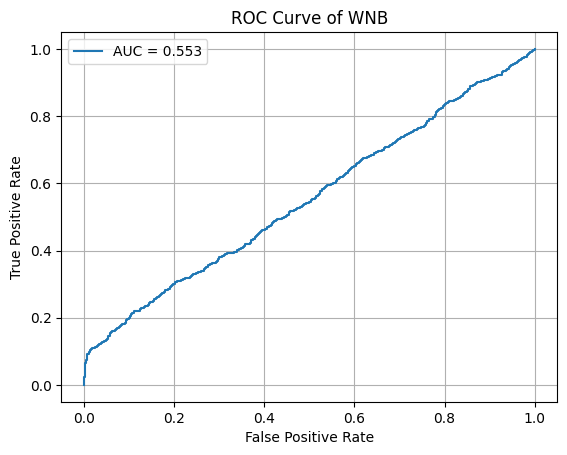

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


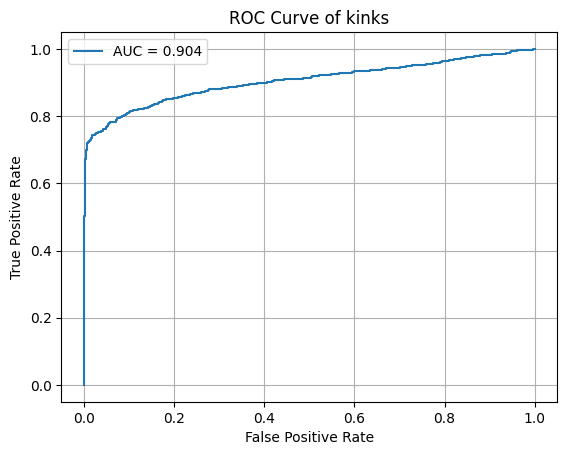

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


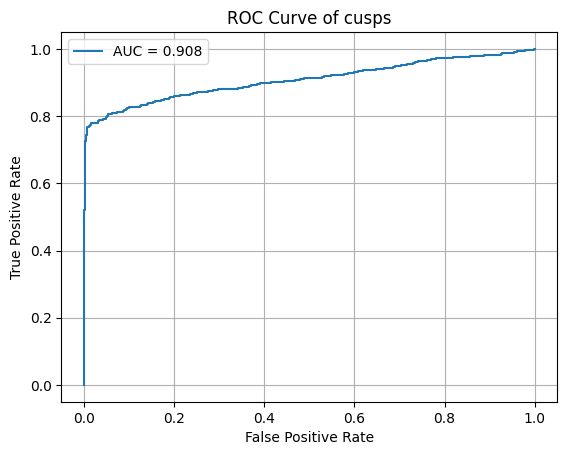

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


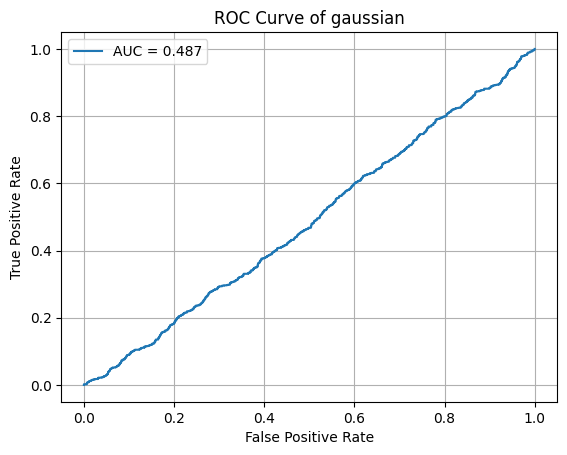

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


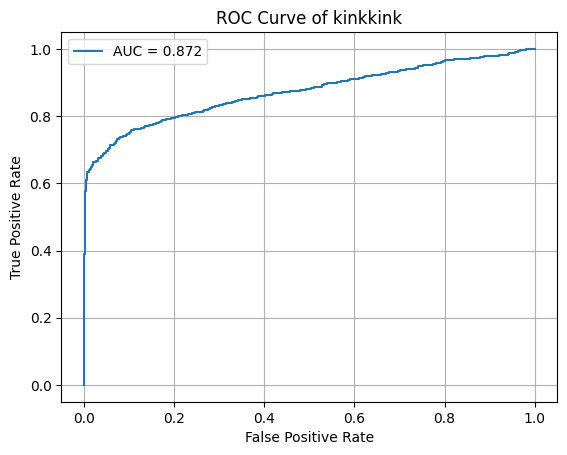

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


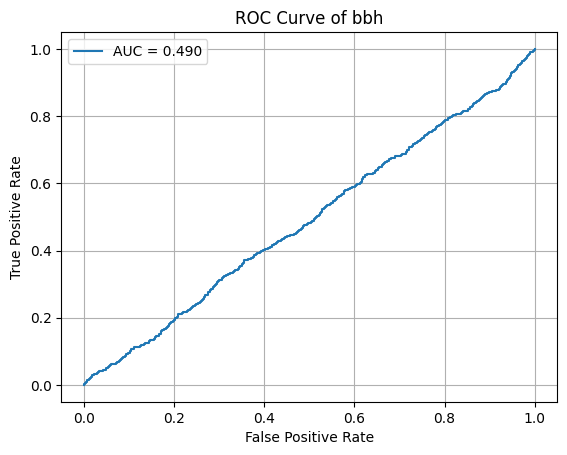

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


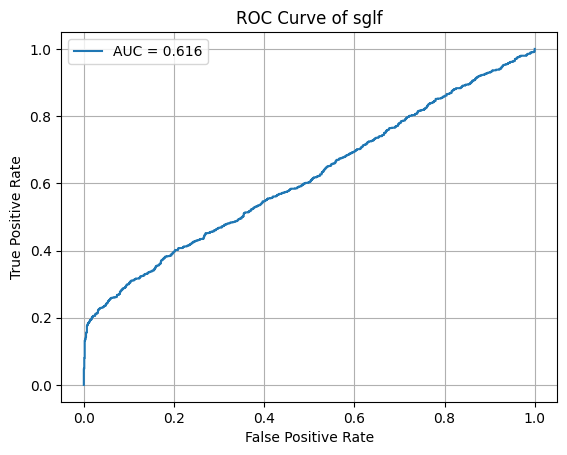

np.float64(0.6158748906551641)

In [69]:
stft_eval(AE, BG_test, WNB, BG_test_stft, WNB_stft, 'WNB')
stft_eval(AE, BG_test, Kink, BG_test_stft, Kink_stft, 'kinks')
stft_eval(AE, BG_test, Cusp, BG_test_stft, Cusp_stft, 'cusps')
stft_eval(AE, BG_test, Gaussian, BG_test_stft, Gaussian_stft, 'gaussian')
stft_eval(AE, BG_test, KinkKink, BG_test_stft, KinkKink_stft, 'kinkkink')
stft_eval(AE, BG_test, BBH, BG_test_stft, BBH_stft, 'bbh')
stft_eval(AE, BG_test, SG, BG_test_stft, SG_stft, 'sglf')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


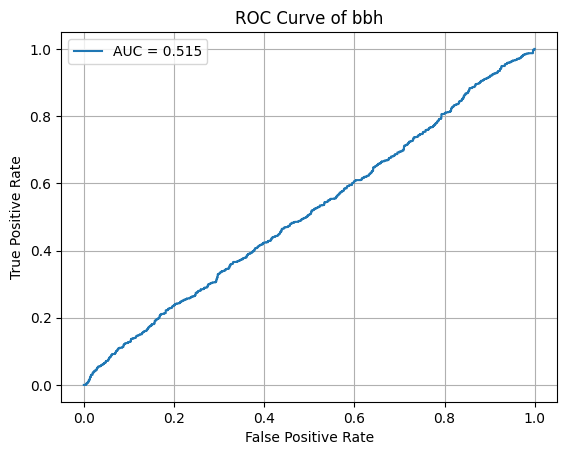

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


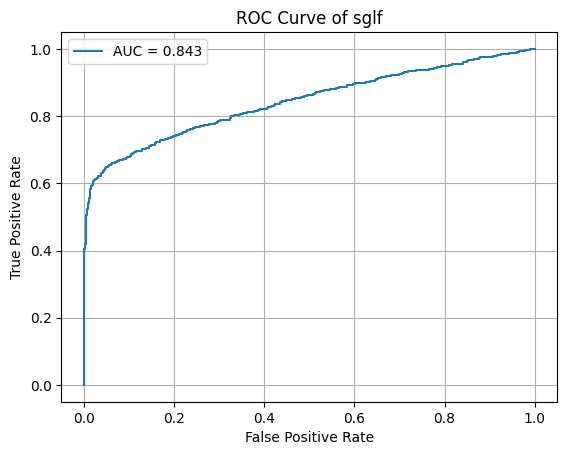

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


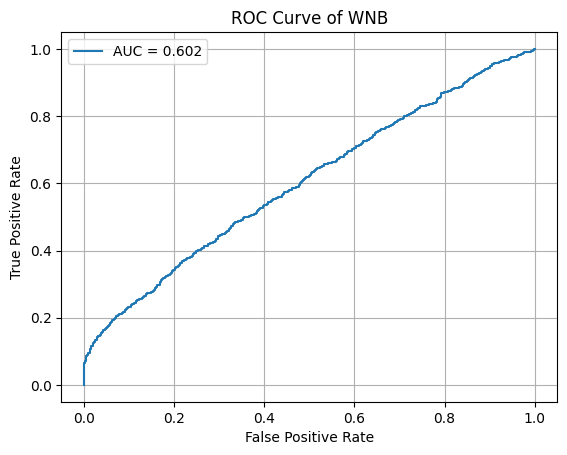

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


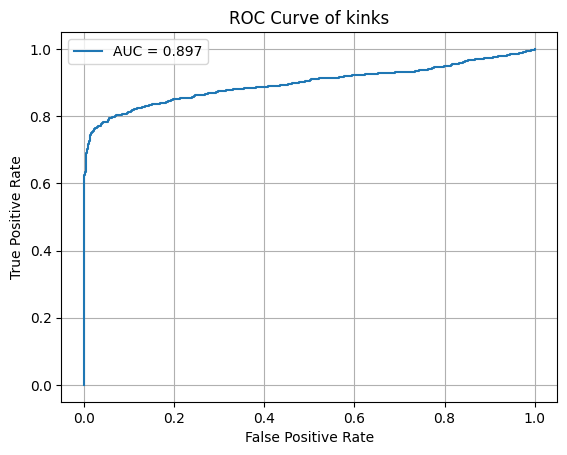

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


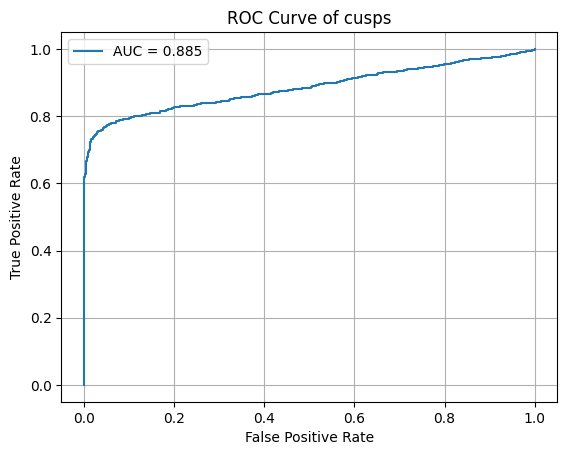

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


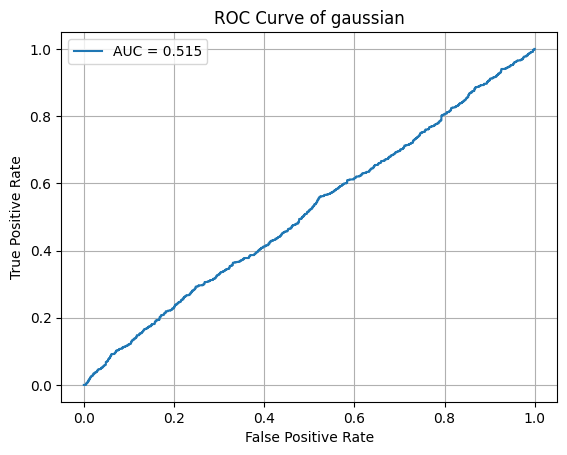

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


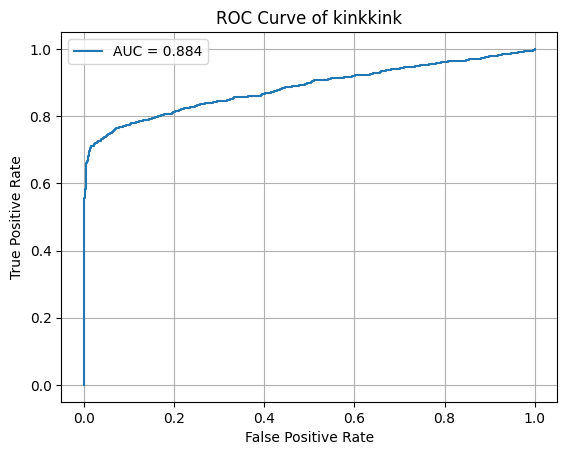

np.float64(0.8839725262964776)

In [70]:
recon_eval(AE, BG_test, BBH, 'bbh')
recon_eval(AE, BG_test, SG, 'sglf')
recon_eval(AE, BG_test, WNB, 'WNB')
recon_eval(AE, BG_test, Kink, 'kinks')
recon_eval(AE, BG_test, Cusp, 'cusps')
recon_eval(AE, BG_test, Gaussian, 'gaussian')
recon_eval(AE, BG_test, KinkKink, 'kinkkink')


In [71]:
# save_dir = '/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_save'

# param_set = [
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 61, 'f2': 22, 'f5': 2, 'k1': 9,  'k2': 15, 'k3': 24, 'k4': 4,  'k5': 6,  'lr': 0.001, 's1': 1, 's2': 2},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 52, 'f2': 29, 'f5': 2, 'k1': 16, 'k2': 6,  'k3': 8,  'k4': 25, 'k5': 4,  'lr': 0.001, 's1': 1, 's2': 2},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 36, 'f2': 29, 'f5': 2, 'k1': 7,  'k2': 14, 'k3': 15, 'k4': 7,  'k5': 3,  'lr': 0.001, 's1': 1, 's2': 2},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 60, 'f2': 21, 'f5': 2, 'k1': 10, 'k2': 34, 'k3': 26, 'k4': 3,  'k5': 8,  'lr': 0.001, 's1': 1, 's2': 1},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 38, 'f2': 28, 'f5': 2, 'k1': 22, 'k2': 21, 'k3': 27, 'k4': 31, 'k5': 8,  'lr': 0.001, 's1': 1, 's2': 2},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 40, 'f2': 14, 'f5': 2, 'k1': 4,  'k2': 8,  'k3': 20, 'k4': 29, 'k5': 8,  'lr': 0.001, 's1': 1, 's2': 1},
#     {'batch_size': 256, 'dropout': 0.1, 'epochs': 50, 'f1': 62, 'f2': 16, 'f5': 2, 'k1': 4,  'k2': 14, 'k3': 37, 'k4': 34, 'k5': 5,  'lr': 0.001, 's1': 1, 's2': 2}
# ]

# for i, params in enumerate(param_set):
#     autoencoder = Autoencoder(**params, input_shape=(200, 2))
#     autoencoder.build_model()
#     autoencoder.model_.fit(
#         x_train, x_train,
#         epochs=params['epochs'],
#         batch_size=params['batch_size'],
#         verbose=1,
#         callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
#     )
#     autoencoder.model_.save(f"/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_save/model_{i}.keras")
#     print(f"✅ Saved model_{i}.keras")

In [72]:
# def eval(model, bg, anomaly):
#     bg_pred = model.predict(bg)
#     anomaly_pred = model.predict(anomaly)
#     bg_mse = np.mean((bg_pred - bg)**2, axis=(1,2))
#     anomaly_mse = np.mean((anomaly_pred - anomaly)**2, axis=(1,2))

#     true_val = np.concatenate((np.zeros(bg.shape[0]),np.ones(anomaly.shape[0])))
#     pred_val = np.concatenate((bg_mse, anomaly_mse))

#     fpr, tpr, thresholds = roc_curve(true_val, pred_val)
#     auc_score = auc(fpr, tpr)
#     return auc_score

# # def eval(model, bg, anomaly):
# #     bg_pred = model.predict(bg)
# #     anomaly_pred = model.predict(anomaly)

# #     bg_mse = np.mean((bg_pred - bg) ** 2, axis=(1, 2))
# #     anomaly_mse = np.mean((anomaly_pred - anomaly) ** 2, axis=(1, 2))

# #     true_val = np.concatenate((np.zeros(bg.shape[0]), np.ones(anomaly.shape[0])))
# #     pred_val = np.concatenate((bg_mse, anomaly_mse))

# #     auc = roc_auc_score(true_val, pred_val)
# #     return auc

# model_files = glob.glob("/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_save/model_*.keras")
# model_files = sorted(model_files, key=lambda x: int(re.search(r"model_(\d+).keras", x).group(1)))
# for model_file in model_files:
#     model = keras_load_model(model_file)
#     auc_bbh = eval(model,background_test,bbh_test)
#     auc_sglf = eval(model,background_test,sglf_test)
#     auc_test = eval(model,background_test_data, signal_test_data)
#     print(f"✅ Evaluation of model {model_file}: BBH AUC = {auc_bbh}, SG AUC = {auc_sglf}, Test AUC = {auc_test}")

